In [24]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
#import pandas as pd

In [25]:
class Control(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #para cuando truene
        self.model = model
        
        self.contar()
        self.cambio_luz()
        self.timer = 10
        
    def step(self):
        self.contar()
        
        if self.timer == 0:
            self.cambio_luz()
            self.timer = 10
        
        self.timer -= 1
            
        
    def cambio_luz(self):
        if(self.cont_norte == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.norte.light = True
            self.model.sur.light = False
            self.model.este.light = False
            self.model.oeste.light = False
        elif(self.cont_sur == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.norte.light = False
            self.model.sur.light = True
            self.model.este.light = False
            self.model.oeste.light = False
        elif(self.cont_este == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.norte.light = False
            self.model.sur.light = False
            self.model.este.light = True
            self.model.oeste.light = False
        elif(self.cont_oeste == max(self.cont_norte,max(self.cont_sur,max(self.cont_este,self.cont_oeste)))):
            self.model.norte.light = False
            self.model.sur.light = False
            self.model.este.light = False
            self.model.oeste.light = True
        
    
    def contar(self):
        self.cont_norte = 0
        self.cont_sur = 0
        self.cont_este = 0
        self.cont_oeste = 0
        for agent in self.model.schedule.agents:
            if agent.orientation == 'up-down' and 12 <= agent.position[1] <= 40 and 0 <= agent.position[0] <= 2:
                self.cont_norte += 1
            elif agent.orientation == 'down-up' and -40 <= agent.position[1] <= -12 and -2 <= agent.position[0] <= 0:
                self.cont_sur += 1
            elif agent.orientation == 'right-left' and 12 <= agent.position[0] <= 40 and -2 <= agent.position[1] <= 0:
                self.cont_este += 1
            elif agent.orientation == 'left-right' and -40 <= agent.position[0] <= -12 and 0 <= agent.position[1] <= 2:
                self.cont_oeste += 1
                

In [26]:
class Semaforo(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        self.light = False

In [27]:
class Coche(Agent):
    def __init__(self, unique_id, model, x, y, orientation):
        super().__init__(unique_id, model)
        
        # Posición del coche
        self.position = np.array((x,y), dtype=np.float64)
        
        # Orientación del coche
        self.orientation = orientation
        
        # Vector de velocidad y aceleración del coche
        self.check_speed()
        
        # Variables para la vuelta
        self.index = 0
        self.turn = False
        
    def step(self):
        self.check_speed()
        
        if self.stop() == False:
            self.check_turn()
            if self.turn == True:
                if self.index < len(self.curve):
                    self.position = self.curve[self.index]
                    self.index += 1
                else:
                    self.turn = False
                    self.index = 0
            elif self.turn == False:
                self.position = self.position + self.velocity
            

    def check_speed(self):
        # Horizontal de derecha a izquierda
        if self.orientation == 'right-left':
            vel = -4
            self.velocity = np.array((vel, 0), dtype=np.float64)
            
        # Vertical de arriba hacia abajo
        elif self.orientation == 'up-down':
            vel = -4
            self.velocity = np.array((0, vel), dtype=np.float64)
        
        # Horizontal de izquierda a derecha
        elif self.orientation == 'left-right':
            vel = 4
            self.velocity = np.array((vel, 0), dtype=np.float64)
            
        # Vertical de abajo hacia arriba
        elif self.orientation == 'down-up':
            vel = 4
            self.velocity = np.array((0, vel), dtype=np.float64)
    
    def stop(self):
        if self.orientation == 'right-left' and self.position.flatten()[0] == 12: 
            if model.este.light == False:
                return True

        elif self.orientation == 'up-down' and self.position.flatten()[1] == 12:
            if model.norte.light == False:
                return True

        elif self.orientation == 'left-right' and self.position.flatten()[0] == -12:
            if model.oeste.light == False:
                return True

        elif self.orientation == 'down-up' and self.position.flatten()[1] == -12:
            if model.sur.light == False:
                return True
        
        if self.check_cars() == True:
            return True
        
        return False
    
    def check_cars(self):
        for agent in model.schedule.agents:

            if self.orientation == 'right-left':
                # Carril 1
                if self.position[1] == 0:
                    if self.position[0] - 4 == agent.position[0] and self.position[1] - agent.position[1] == 0:
                        return True
                # Carril 2
                elif self.position[1] == 4:
                    if self.position[0] - 4 == agent.position[0] and self.position[1] - agent.position[1] == 0:
                        return True
            
            elif self.orientation == 'left-right':
                # Carril 1
                if self.position[1] == 0:
                    if self.position[0] + 4 == agent.position[0] and self.position[1] - agent.position[1] == 0:
                        return True
                # Carril 2
                elif self.position[1] == -4:
                    if self.position[0] + 4 == agent.position[0] and self.position[1] - agent.position[1] == 0:
                        return True
    
            elif self.orientation == 'up-down':
                # Carril 1
                if self.position[0] == 0:
                    if self.position[1] - 4 == agent.position[1] and self.position[0] - agent.position[0] == 0:
                        return True
                # Carril 2
                elif self.position[0] == - 4:
                    if self.position[1] - 4 == agent.position[1] and self.position[0] - agent.position[0] == 0:
                        return True
            
            elif self.orientation == 'down-up':
                # Carril 1
                if self.position[0] == 0:
                    if self.position[1] + 4 == agent.position[1] and self.position[0] - agent.position[0] == 0:
                        return True
                # Carril 2
                elif self.position[0] == 4:
                    if self.position[1] + 4 == agent.position[1] and self.position[0] - agent.position[0] == 0:
                        return True
            
        return False
    
    
    def check_turn(self):
        choice = np.random.choice([True,False])
        
        # Vuelta a la derecha
        if self.orientation == 'right-left' and self.position.flatten()[0] == 12 and self.position.flatten()[1] == 4: 
            if choice == True:
                self.curve = np.array([[9.72,4.72], [7.55,6.14], [6,8], [4.65,10.01], [4,11.9]])
                self.turn = True
                self.orientation = 'down-up'
            
        elif self.orientation == 'down-up' and self.position.flatten()[0] == 4 and self.position.flatten()[1] == -12: 
            if choice == True:
                self.curve = np.array([[5.02,-10.04], [6.54,-7.83], [8,-6], [10.27,-4.69], [11.9,-4]])
                self.turn = True
                self.orientation = 'left-right'
            
        elif self.orientation == 'left-right' and self.position.flatten()[0] == -12 and self.position.flatten()[1] == -4: 
            if choice == True:
                self.curve = np.array([[-9.72,-4.72], [-7.55,-6.14], [-6,-8], [-4.65,-10.01], [-4,-11.9]])
                self.turn = True
                self.orientation = 'up-down'
            
        elif self.orientation == 'up-down' and self.position.flatten()[0] == -4 and self.position.flatten()[1] == 12: 
            if choice == True:
                self.curve = np.array([[-5.02,10.04], [-6.54,7.83], [-8,6], [-10.27,4.69], [-11.9,4]])
                self.turn = True
                self.orientation = 'right-left'
        
        # Vuelta izquierda
        if self.orientation == 'right-left' and self.position.flatten()[0] == 12 and self.position.flatten()[1] == 0:
            self.curve = np.array([[9.54,-0.95], [6.96,-2.0], [5.07,-3.36], [3.27,-4.77], [-1.17,-6.29], [-0.69,-7.99], [-2.0,-10.0], [-4,-11.9]])
            self.turn = True
            self.orientation = 'up-down'
                
        elif self.orientation == 'up-down' and self.position.flatten()[0] == 0 and self.position.flatten()[1] == 12:
            self.curve = np.array([[0.84,9.57], [2.11,7.13], [3.33,4.61], [4.75,1.69], [6.49,-0.63], [8.14,-1.6], [10.05,-3.02], [11.9,-4]])
            self.turn = True
            self.orientation = 'left-right'
                
        elif self.orientation == 'left-right' and self.position.flatten()[0] == -12 and self.position.flatten()[1] == 0:
            self.curve = np.array([[-9.54,0.95], [-6.96,2.0], [-5.07,3.36], [-3.27,4.77], [1.17,6.29], [0.69,7.99], [2.0,10.0], [4,11.9]])
            self.turn = True
            self.orientation = 'down-up'
                
        elif self.orientation == 'down-up' and self.position.flatten()[0] == 0 and self.position.flatten()[1] == -12:
            self.curve = np.array([[-0.84,-9.57], [-2.11,-7.13], [-3.33,-4.61], [-4.75,-1.69], [-6.49,0.63], [-8.14,1.6], [-10.05,3.02], [-11.9,4]])
            self.turn = True
            self.orientation = 'right-left'

#### Vuelta derecha

de 12,4 a 4,12

[6,8], [7.55,6.14], [9.72,4.71], [4.65,10.01], [4,12]

de 4,-12 a 12,-4

[5.02,-10.04], [6.54,-7.83], [8,-6], [10.27,-4.69], [12,-4]

de -12,-4 a -4,-12

[-6,-8], [-7.55,-6.14], [-9.72,-4.71], [-4.65,-10.01], [-4,-12]

de -4,12 a -12,4

[-5.02,10.04], [-6.54,7.83], [-8,6], [-10.27,4.69], [-12,4]

#### Vuelta izquierda

de 12,0 a -4,-12

[9.54,-0.95], [6.96,-2.0], [5.07,-3.36], [3.27,-4.77], [-1.17,-6.29], [-0.69,-7.99], [-2.0,-10.0], [-4,-12]

de 0,12 a 12,-4

[0.84,9.57], [2.11,7.13], [3.33,4.61], [4.75,1.69], [6.49,-0.63], [8.14,-1.6], [10.05,-3.02], [12,-4]

de -12,0 a 4,12

[-9.54,0.95], [-6.96,2.0], [-5.07,3.36], [-3.27,4.77], [1.17,6.29], [0.69,7.99], [2.0,10.0], [4,12]

de 0,-12 a -12,4

[-0.84,-9.57], [-2.11,-7.13], [-3.33,-4.61], [-4.75,-1.69], [-6.49,0.63], [-8.14,1.6], [-10.05,3.02], [-12,4]

In [28]:
def get_cars(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

def get_lights(model):
    result = []
    for agent in model.lights.agents:
        result.append(agent.light)
    result = np.asarray(result)
    return result

class CarModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.lights = RandomActivation(self)
        
        self.iniciar_semaforos()
        self.control = Control(1, self)
        
        self.id = 8
        
        self.source = np.array([[40, 0], [40, 4], [0, 40], [-4, 40], [-40, 0], [-40, -4], [0, -40], [4, -40]])
        temp = []
        i = 0
        
        g = np.random.randint(8)
        while i in range(g):
            pos = np.random.randint(8)
            
            if pos in temp:
                continue
            
            x = self.source[pos][0]
            y = self.source[pos][1]
            orientation = self.initial_orientation(pos)
            car = Coche(i, self, x, y, orientation)
            self.schedule.add(car)
            temp.append(pos)
            i += 1

            
        self.datacollector = DataCollector(model_reporters = {"Coches" : get_cars, "Luces" : get_lights})
            
    def step(self):
        if self.id < self.num_agents:
            pos = np.random.randint(8)
            x = self.source[pos][0]
            y = self.source[pos][1]
            orientation = self.initial_orientation(pos)
            car = Coche(self.id, self, x, y, orientation)
            self.schedule.add(car)
            self.id += 1
        
        self.datacollector.collect(self)
        self.schedule.step()
        self.control.step()
        
    def initial_orientation(self, pos):
        if 0 <= pos <= 1:
            return 'right-left'
        elif 2 <= pos <= 3:
            return 'up-down'
        elif 4 <= pos <= 5:
            return 'left-right'
        elif 6 <= pos <= 7:
            return 'down-up'
        
    def iniciar_semaforos(self):
        self.norte = Semaforo(1, self)
        self.sur = Semaforo(2, self)
        self.este = Semaforo(3, self)
        self.oeste = Semaforo(4, self)
        
        self.lights.add(self.norte)
        self.lights.add(self.sur)
        self.lights.add(self.este)
        self.lights.add(self.oeste)
        
            

In [29]:
MAX_GENERATIONS = 70
N = 20

model = CarModel(N)

for i in range(MAX_GENERATIONS):
    model.step()

In [30]:
all_positions = model.datacollector.get_model_vars_dataframe()
#for i in range(MAX_GENERATIONS):
#    print(all_positions.iloc[i][0][0])

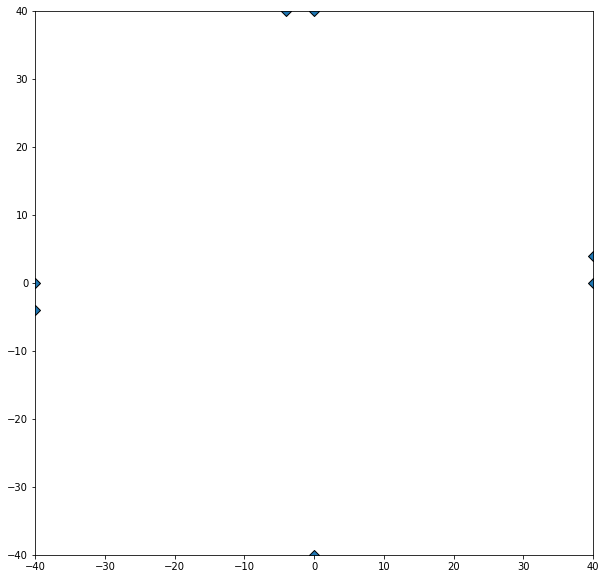

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1],
                     s=50, cmap="jet", edgecolor="k", marker="D")
ax.axis([-40, 40, -40, 40])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_GENERATIONS)

In [32]:
anim